# Finance PB

In [1]:
import os
import dotenv

dotenv.load_dotenv()
token = os.getenv('TUSHARE_TOKEN')

In [2]:
import tushare as ts

ts.set_token(token)
pro = ts.pro_api()

In [3]:
# 获取交易日历
start_date = '20230101'

import datetime
now = datetime.datetime.now()
trade_cal = pro.trade_cal(exchange='', start_date=start_date, end_date=now.strftime('%Y%m%d'), is_open='1')

In [4]:
# 获取当前交易日所有股票的交易数据
import pandas as pd
daily_basic = pd.DataFrame()
for date in trade_cal['cal_date']:
    year = date[:4]
    cache_file = os.path.join('cache', 'daily_basic', year, f'{date}.pkl')
    if os.path.exists(cache_file):
        df = pd.read_pickle(cache_file)
    else:
        print(f'query: {date}')
        df = pro.daily_basic(ts_code='', trade_date=date, fields='ts_code,trade_date,turnover_rate,volume_ratio,pe,pb')
        if df is not None:
            os.makedirs(os.path.dirname(cache_file), exist_ok=True)
            df.to_pickle(cache_file)
    daily_basic = pd.concat([daily_basic, df])
daily_basic = daily_basic.reset_index(drop=True)

In [5]:
# 按交易日统计
grouped = daily_basic.groupby('trade_date').agg(
    total_record_count=('ts_code', 'count'),
    count_pe_le_15=('pe', lambda x: (x <= 15).sum()),
    count_pe_le_10=('pe', lambda x: (x <= 10).sum()),
    count_pb_le_1_5=('pb', lambda x: (x <= 1.5).sum()),
    count_pb_le_1=('pb', lambda x: (x <= 1).sum()),
    count_pb_le_0_75=('pb', lambda x: (x <= 0.75).sum()),
    count_pe_pb_le_22_5=('pe', lambda x: ((x * daily_basic['pb']) <= 22.5).sum())
)

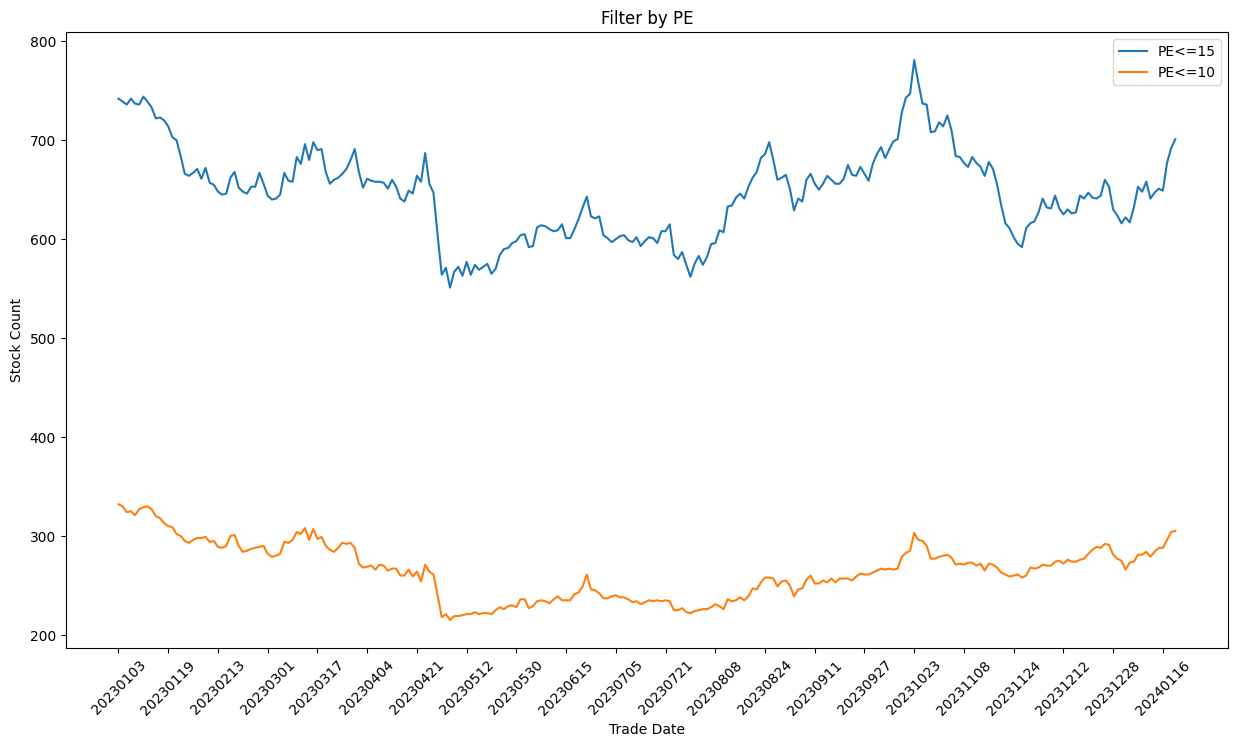

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(grouped.index, grouped['count_pe_le_15'], label='PE<=15')
plt.plot(grouped.index, grouped['count_pe_le_10'], label='PE<=10')

plt.title('Filter by PE')
plt.xlabel('Trade Date')
plt.ylabel('Stock Count')
plt.legend(loc='upper right')

num_ticks = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(grouped.index), len(grouped.index)//num_ticks))

plt.show()

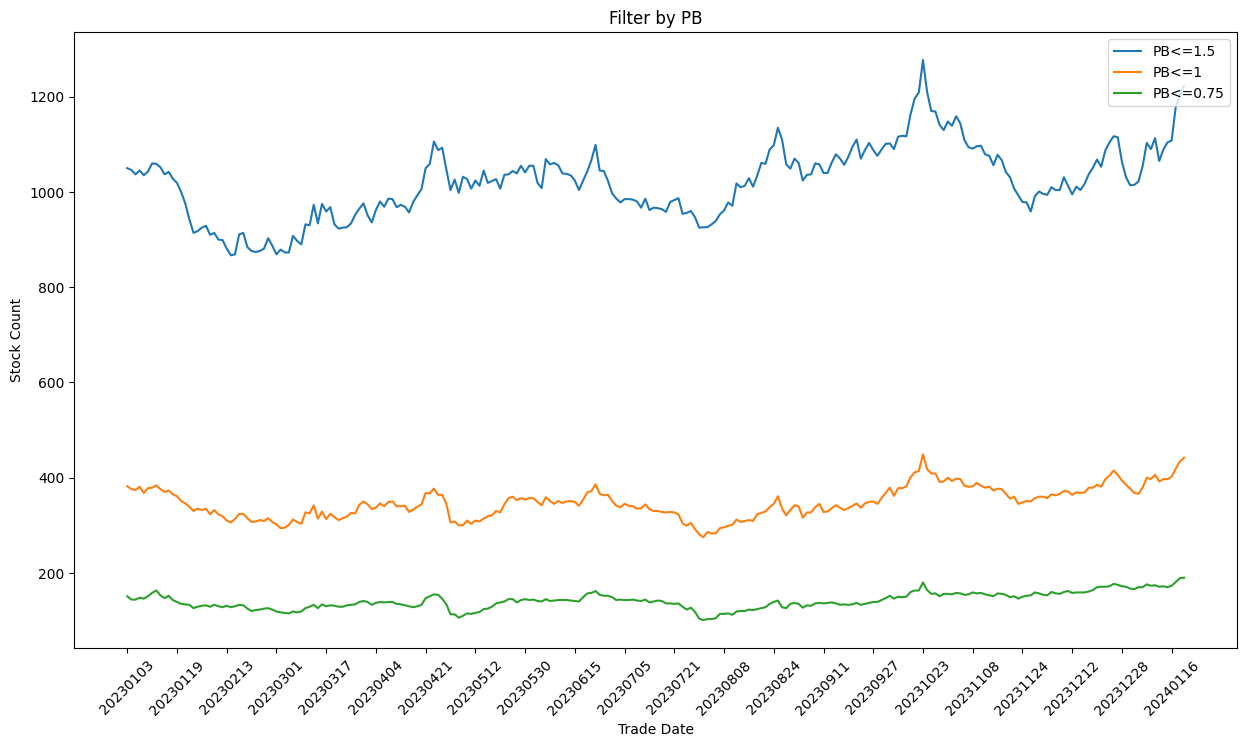

In [7]:
plt.figure(figsize=(15, 8))
plt.plot(grouped.index, grouped['count_pb_le_1_5'], label='PB<=1.5')
plt.plot(grouped.index, grouped['count_pb_le_1'], label='PB<=1')
plt.plot(grouped.index, grouped['count_pb_le_0_75'], label='PB<=0.75')

plt.title('Filter by PB')
plt.xlabel('Trade Date')
plt.ylabel('Stock Count')
plt.legend(loc='upper right')

num_ticks = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(grouped.index), len(grouped.index)//num_ticks))

plt.show()

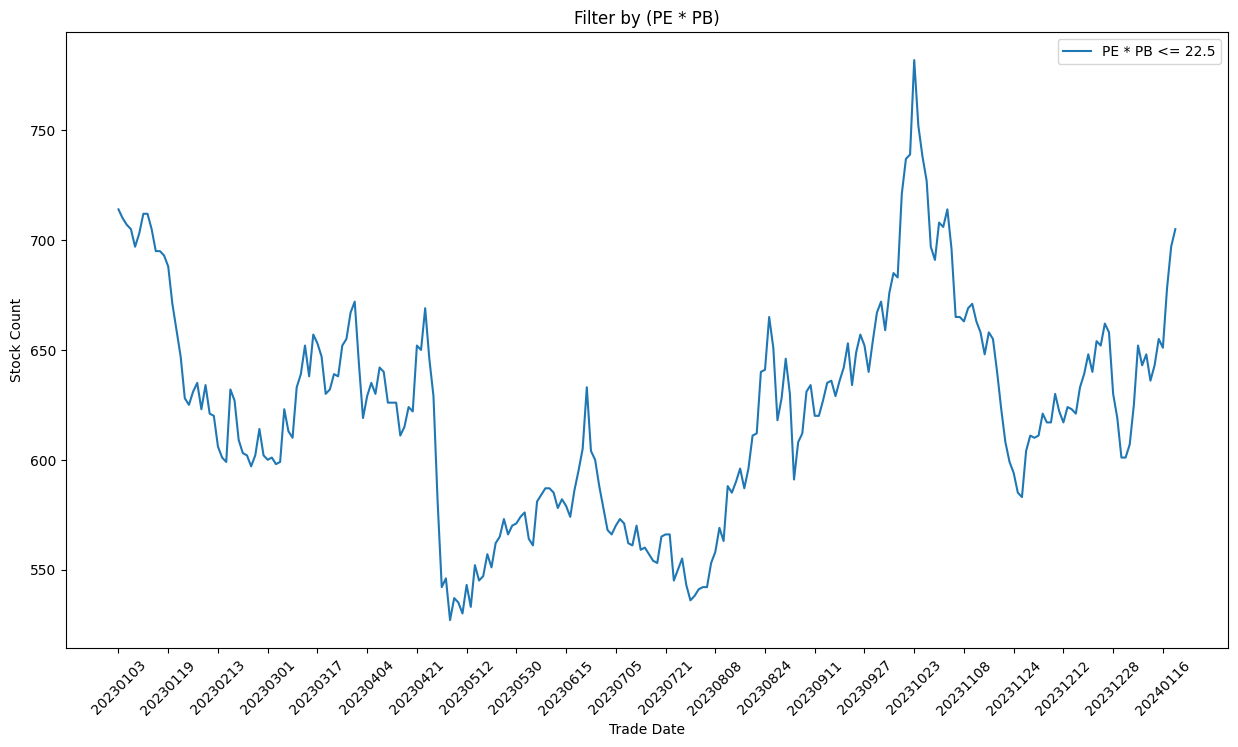

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(grouped.index, grouped['count_pe_pb_le_22_5'], label='PE * PB <= 22.5')

plt.title('Filter by (PE * PB)')
plt.xlabel('Trade Date')
plt.ylabel('Stock Count')
plt.legend(loc='upper right')

num_ticks = 20
plt.xticks(rotation=45)
plt.xticks(range(0, len(grouped.index), len(grouped.index)//num_ticks))

plt.show()